In [1]:
import pandas as pd
import re
import numpy as np

df = pd.read_csv("../data/raw/upload_hak_list_08092024_1528.csv", sep=';')

In [ ]:
# cleaned = pd.read_csv('../data/processed/cleaned_dataset.csv')

In [ ]:
# m = df['QUESTION_clean'].apply(lambda x: bool(re.match(r"^[\x80-\xFF]{5,}", str(x))))

## Первичная обработка

- Удалим prim_id
- Переименуем val1 -> source
- Переведем даты в str

In [2]:
# Удалим prim_id
df = df.drop(columns=df.columns[0])

In [3]:
print(df.columns)
# Переименуем для ясности
df.rename(columns={'VAL1': 'SOURCE'}, inplace=True)

Index(['S_NAME', 'QUESTION', 'ANSWER', 'OPEN_TIME_', 'RESOLVE_TIME_',
       'CLOSE_TIME_', 'ATC_NEXT_BREACH_', 'TITLE', 'SUBCATEGORY', 'REG',
       'PRIORITY', 'AVARIYA', 'VAL1'],
      dtype='object')


In [4]:
# Приведем даты к типу datetime 
for col in ['OPEN_TIME_', 'RESOLVE_TIME_', 'CLOSE_TIME_', 'ATC_NEXT_BREACH_']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

Удалим дубликаты по не временным фичам

In [5]:
not_time_cols = ['QUESTION', 'ANSWER', 'SUBCATEGORY', 'SOURCE', 'TITLE', 'REG', 'AVARIYA', 'S_NAME']

# Сортируем по времени, чтобы первая по времени была первой
df_sorted = df.sort_values(by='OPEN_TIME_')

# Маска дубликатов (оставляем первую по времени)
duplicates_mask = df_sorted.duplicated(subset=not_time_cols, keep='first')

# Индексы строк, которые будут удалены
duplicate_indices = df_sorted[duplicates_mask].index

# Удаляем дубликаты, оставляя первые по времени
df = df_sorted[~duplicates_mask].reset_index(drop=True)

# Проверка
print("Количество удалённых дубликатов:", len(duplicate_indices))
print("Исходный размер:", df.shape)
print("Размер после удаления дубликатов:", df.shape)

# np.save("../data/processed/duplicate_idx.npy", duplicate_indices)

Количество удалённых дубликатов: 212789
Исходный размер: (705687, 13)
Размер после удаления дубликатов: (705687, 13)


Удалим пустые и неинформативные Question

In [6]:
TEXT_PLACEHOLDER = '[NO_TEXT]'

unwanted_patterns = [
    r"\bnan\b",
    r"\bпусто\b",
    r"отсутствует текст описание пустое",
    r"fwd:\s*описание пустое",
    r"пустое описание",
    r"отсутствует текст",
    r"\bотсутствует\b",
    r"\bнету\b",
    r"\bнет\b",
]

def clean_unwanted(text: str) -> str:
    if pd.isna(text):
        return TEXT_PLACEHOLDER
    
    t = str(text).strip()

    for pat in unwanted_patterns:
        # --- unwanted at start ---
        m = re.match(pat, t, re.IGNORECASE)
        if m:
            # If the whole string is basically just the junk → NO_TEXT
            rest = t[m.end():].strip()
            return rest if rest else TEXT_PLACEHOLDER

        # --- unwanted at end ---
        m = re.search(pat + r"\s*$", t)
        if m:
            rest = t[:m.start()].rstrip()
            return rest if rest else TEXT_PLACEHOLDER

    return t


In [7]:
df['QUESTION_clean'] = df['QUESTION'].apply(clean_unwanted)

In [8]:
df[df['QUESTION_clean'] == TEXT_PLACEHOLDER]['QUESTION'].sample(10)

572195    Отсутствует текст Описание пустое
697165    Отсутствует текст Описание пустое
467984    Отсутствует текст Описание пустое
534568    Отсутствует текст Описание пустое
206837                                  NaN
181367    Отсутствует текст Описание пустое
358758    Отсутствует текст Описание пустое
599762    Отсутствует текст Описание пустое
127443                                  NaN
255749    Отсутствует текст Описание пустое
Name: QUESTION, dtype: object

Почистим примеры с системной информацией

In [10]:
import re

def strip_service_info(text: str) -> str:
    if not isinstance(text, str) or len(text.strip()) == 0:
        return TEXT_PLACEHOLDER

    t = text.strip()

    # --- Remove garbled/broken encoding at start ---
    if re.match(r"^[\x80-\xFF]{5,}", t):
        return TEXT_PLACEHOLDER

    # --- Service markers ---
    kill_markers = [
        r"The mail",
        r"Уведомляющий Сервер", 
        r"Postfix Queue ID",
        r"Postfix Sender",
        r"Arrival Date",
        r"Recipient:",
        r"Original Recipient:",
        r"Diagnostic Code",
        r"in reply to RCPT TO command",
        r"Mail received:",
        r"Message ID:",
        r"Receive Notification Mail",
        r"Pronto! HTML5 Feedback Pronto! HTML5 client version"
    ]
    
    strip_left_markers = [
        r"pronto! html5 feedback",
        r"Fwd:",
        r"Fwd: Re:",
        r"Fwd: Fwd:"
    ]

    # Remove all consecutive strip-left markers at the start
    while True:
        t_strip = t
        for pat in strip_left_markers:
            m = re.match(pat, t, re.IGNORECASE)
            if m:
                t = t[m.end():].strip()
                break  # start over to check for next consecutive marker
        if t == t_strip:
            break  # no more markers at start

    # --- Kill markers anywhere ---
    for pat in kill_markers:
        m = re.search(pat, t, re.IGNORECASE)
        if m:
            if m.start() < 10:
                return TEXT_PLACEHOLDER
            t = t[:m.start()].rstrip()

    # Normalize whitespace
    t = re.sub(r"[\n\r\t]+", " ", t)
    t = re.sub(r"\s+", " ", t).strip()

    # If text is too short → [NO_TEXT]
    if len(t.split()) < 1:
        return TEXT_PLACEHOLDER

    return t


In [11]:
df['QUESTION_clean'] = df['QUESTION_clean'].apply(strip_service_info).apply(clean_unwanted)

In [13]:
print(df['QUESTION'].str.contains('The mail').sum())
df['QUESTION_clean'].str.contains('The mail').sum()

4823


0

In [66]:
df['QUESTION_clean'].sample(10)

28949     Заявка на создание учетных записей ОП по Совет...
271722    Добрый день. До сих пор не работает "Хвост" в ...
345258         просьба удалить все данные в исх. №31/6 1801
41740     Входящие документы 13249 и 13467 находятся в р...
19609     НЕ ИДЕТ НА РАСПЕЧАТЫВАНИЕ СПЕЦПРОДУКЦИЯ (ВОДИТ...
451970                Программа не дает сохранить материал.
607813                    Восстановление пароля УЗ САФРОНОВ
195072    "В связи с назначением на должность начальник ...
564870                                            Моргунова
46016     Здравствуйте. Не удаляются входящие письма, ош...
Name: QUESTION_clean, dtype: object

Отфильтруем чувствительные данные. В feature_engeneering из них получатся булевы фичи для классификаторов

In [ ]:
# Паттерны для чувствительных данных
SENSITIVE_PATTERNS = {
    "EMAIL": r'\b[A-Za-z0-9._%+-]+@(?:[A-Za-z0-9-]+\.)+[A-Za-z]{2,}\b|<".+?"@[^>]+>',
    "INN": r'(?i)инн\s*\d{5,12}',
    "PHONE": r'\b(?:\+7|8)?[\s-]?\(?\d{3,4}\)?[\s-]?\d{2,3}[\s-]?\d{2}[\s-]?\d{2}(?:\s*\(доб\.\s*\d+\))?\b',
    # "PHONE_EXT": r'\b8\s?\d{3,4}[\s-]?\d{2}[\s-]?\d{2}[\s-]?\d{2}(?:\s*\(доб\.\s*\d+\))?',
    "VIN": r'\b[A-HJ-NPR-Z0-9]{17}\b',
    "INCEDENT": r'\bIM\d{8-12}\b',
    "REG_NUMBER": r'\b[АВЕКМНОРСТУХ]{1,3}\d{3,4}[АВЕКМНОРСТУХ]{2}\b',
    "CASE_NO": r'\b(?:[CcSs]D|T)\d{6,10}\b',
    "APPEAL_NO": r'\b\d/\d{9,12}\b',
    "DOC_NO": r'№\s?\d{1,6}([/\\-]?\d{1,6})?([А-ЯA-Z])?',
    "LONG_ID": r'\b\d{9,}\b|\b[a-f0-9]{32,128}\b|(?:UID|GlndID|GUID)[: ]?[0-9a-fA-F\-]{16,128}',
    "IP": r'\b(?:\d{1,3}\.){3}\d{1,3}\b',
    "DATE": r'\b\d{2}[./-]\d{2}[./-]\d{2,4}(?:\s?г\.?)?',
    "FIO": r'\b[А-ЯЁ][а-яё]+ [А-ЯЁ]\.[А-ЯЁ]\.(?=[\s,.)/]|$)',
    "USERNAME": r'\b[a-zA-Z][a-zA-Z0-9]{3,15}\d\b',
    "TOKEN": r'\b[a-f0-9]{16,64}\b|\b(?=.*[A-Z])(?=.*[a-z])(?=.*\d)[A-Za-z0-9]{12,64}\b',
    "URL": r'https?://[^\s]+',
}

def clean_text_for_rag(text: str) -> str:
    """Очистка текста для RAG и эмбеддингов"""
    if not isinstance(text, str) or text.strip() == "":
        return "[NO_TEXT]"
    
    cleaned = text
    
    # Убираем HTML
    cleaned = re.sub(r"<.*?>", " ", cleaned)
    
    # Заменяем чувствительные данные на плейсхолдеры
    for placeholder, pattern in SENSITIVE_PATTERNS.items():
        cleaned = re.sub(pattern, f"[{placeholder}]", cleaned, flags=re.IGNORECASE)
    
    # Управляющие символы и нормализация пробелов
    cleaned = re.sub(r"[\n\r\t]+", " ", cleaned)
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    
    # Если после очистки текст слишком короткий → ставим [NO_TEXT]
    if len(cleaned.split()) < 2:
        cleaned = TEXT_PLACEHOLDER
    
    return cleaned

def anonymize_for_training(text: str) -> str:
    """
    Заменяет конфиденциальные данные на теги, но сохраняет окружающий контекст.
    Если после этого текст становится пустым или бессмысленным, возвращает [NO_TEXT].
    """
    if not isinstance(text, str) or text.strip() == "":
        return "[NO_TEXT]"
    
    cleaned = text
    
    # 1. Убираем HTML (остается)
    cleaned = re.sub(r"<.*?>", " ", cleaned)
    
    # 2. Заменяем чувствительные данные на плейсхолдеры (ГЛАВНОЕ ИЗМЕНЕНИЕ!)
    #    Эта операция заменяет только совпавшие паттерны, а не весь текст.
    for placeholder, pattern in SENSITIVE_PATTERNS.items():
        cleaned = re.sub(pattern, f"[{placeholder}]", cleaned, flags=re.IGNORECASE)
    
    # 3. Управляющие символы и нормализация пробелов (остается)
    cleaned = re.sub(r"[\n\r\t]+", " ", cleaned)
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    
    # 4. КРИТИЧЕСКИ ВАЖНЫЙ НОВЫЙ ЭТАП: Анализ результата замены.
    # Разбиваем текст на слова
    words = cleaned.split()
    
    # Считаем, сколько у нас "живых" слов (не тегов)
    normal_word_count = sum(1 for word in words if not re.match(r'^\[[А-ЯA-Z_]+\]$', word))
    
    # Если после очистки не осталось ни одного нормального слова (одни теги)...
    if normal_word_count == 0:
        # ...и при этом тегов больше одного, maybe есть контекст? Но обычно нет.
        # Лучшая стратегия: пометить как [NO_TEXT]
        cleaned = "[NO_TEXT]"
    # Если осталось хоть одно нормальное слово - оставляем текст как есть, даже если он короткий.
    # Например: "Сбой [CASE_NO]" - это ценный пример для классификатора
    return cleaned


In [89]:
df['QUESTION_clean'] = df['QUESTION_clean'].map(anonymize_for_training)

In [90]:
for key in SENSITIVE_PATTERNS.keys():
    print(f'{key}: {df['QUESTION_clean'].str.contains(key).sum()}')

EMAIL: 39691
INN: 471
PHONE: 39800
VIN: 2188
INCEDENT: 0
REG_NUMBER: 70
CASE_NO: 70719
APPEAL_NO: 24500
DOC_NO: 51743
LONG_ID: 34595
IP: 6923
DATE: 136358
FIO: 163009
USERNAME: 33572
TOKEN: 7070
URL: 5477


In [168]:
cleaned = pd.read_csv('../data/processed/cleaned_dataset.csv')

In [169]:
m = cleaned["QUESTION_clean"] != df['QUESTION_clean']

In [170]:
a = pd.concat([df[m][['QUESTION_clean']], cleaned[m]['QUESTION_clean']], axis=1)

In [178]:
df['QUESTION_clean'].sample(10)

18232                                      Сброс пароля ЭКЦ
535138    Описание обращения: "при работе в ГИСМУ миграц...
387678    Прошу добавить пользователя в сервис СПГУ, ОМУ...
689457             Добрый день. Заявка на присвоение ролей.
556347    предложение в модуль участковый: при распечатк...
376309    ОМВД России по Дмитровскому р ну не работает С...
414356    В отчет по снятию с миграционного учета не поп...
240449    СЦ 2914807 Уважаемые коллеги! В ответе от серв...
190069    Просьба зарегистрировать обращение на блокиров...
323593    Здравствуйте, модуль "Участковый", снимите с п...
Name: QUESTION_clean, dtype: object

In [179]:
cleaned["QUESTION_clean"] = df['QUESTION_clean']

In [180]:
cleaned.to_csv('../data/processed/cleaned_dataset.csv')

In [ ]:
df['QUESTION_clean'].to_csv('../data/question_texts.csv')

То же самое для Answer

In [1133]:
df['ANSWER_clean'] = df['ANSWER'].map(strip_service_info)

In [1134]:
df['ANSWER_clean'] = df['ANSWER_clean'].map(clean_text_for_rag)

In [1135]:
df[['ANSWER', 'ANSWER_clean']].sample(10).values

array([['Необходимые корректировки внесены согласно заявке',
        'Необходимые корректировки внесены согласно заявке'],
       ['Для удаления постановления необходимо в рамках нового обращения в ЕЦЭ ИСОД МВД России предоставить выгрузку из раздела «Аналитика» модуля «Административная практика» СООП с обязательным наличием поля «Идентификатор дела в СООП»',
        'Для удаления постановления необходимо в рамках нового обращения в ЕЦЭ ИСОД МВД России предоставить выгрузку из раздела «Аналитика» модуля «Административная практика» СООП с обязательным наличием поля «Идентификатор дела в СООП»'],
       ['Отображение документа скорректировано согласно заявке',
        'Отображение документа скорректировано согласно заявке'],
       ['Услуга ДОПОГ функционирует в тестовом режиме, поэтому возникают ошибки и затруднения. Услуга находится в процессе доработки\\модернизации',
        'Услуга ДОПОГ функционирует в тестовом режиме, поэтому возникают ошибки и затруднения. Услуга находится в проц

In [1140]:
df_copy = df.copy()

## Обработка Subcategory

- Найдем опечатки и похожие названия
- Сольем редкие классы в "Прочее"
- Создадим маппинг для будущей модели

In [1141]:
df['SUBCATEGORY'].value_counts()

SUBCATEGORY
Доступ к ИСОД                                      252951
Прочее                                             207771
Запрос на администрирование                        105941
Прочие вопросы                                      83282
Настройка ПО и оборудования                         15032
Авария                                              11155
Коррекция данных                                     7076
ОШС                                                  5588
Консультация                                         4410
Программное обеспечение.Региональные ПТК             3771
Запрос статуса                                       3575
Программное обеспечение                              1817
СПГУ.Несколько модулей                               1510
Запрос на доработку                                   925
Оборудование                                          205
СПГУ                                                  182
Инцидент                                              100
За

Много мусорных классов. Подавляющее большинство в топ-4 класса. 

Объединим опечатки и похожие кассы, сольем мусорные классы в "Прочее".

In [1144]:
from rapidfuzz import process, fuzz
import json

SIMILARITY_SCORE = 85

# 1. Ищем похожие классы по Левенштейну
unique_classes = df['SUBCATEGORY'].unique()
similar_map = {}

# Аггрегируем классы со схожестью > 90
for cls in unique_classes:
    matches = process.extract(
        cls, 
        unique_classes, 
        scorer=fuzz.ratio, 
        limit=None
    )
    similar_map[cls] = [m[0] for m in matches if m[0] != cls and m[1] >= SIMILARITY_SCORE]

In [1146]:
print(f"\nПохожие классы (порог {SIMILARITY_SCORE}%):")
for k, v in similar_map.items():
    if v:
        print(f"- {k} -> {v}")


Похожие классы (порог 85%):
- Программное обеспечение.Региональные ПТК -> ['Программное обеспечение. Региональные ПТК', 'Програмное обеспечение. Региональные ПТК', 'Программное обеспечене. Региональные ПТК', 'Програмное обеспечение. Региональное ПТК']
- СПГУ.Несколько модулей -> ['СПГУ. Несколько модулей']
- СПГУ. Несколько модулей -> ['СПГУ.Несколько модулей']
- Програмное обеспечение. Региональное ПТК -> ['Програмное обеспечение. Региональные ПТК', 'Программное обеспечение. Региональные ПТК', 'Программное обеспечение.Региональные ПТК', 'Программное обеспечене. Региональные ПТК']
- Запрос на консультацию в СОБТ -> ['Запрос на консультацию']
- Запрос на консультацию -> ['Запрос на консультацию в СОБТ']
- Програмное обеспечение. Региональные ПТК -> ['Программное обеспечение. Региональные ПТК', 'Программное обеспечение.Региональные ПТК', 'Програмное обеспечение. Региональное ПТК', 'Программное обеспечене. Региональные ПТК']
- Программное обеспечение. Региональные ПТК -> ['Программное об

In [1148]:
# Объединим похожие классы с учётом референсных (с правильным написанием)

PREFERRED_SUBCATS = ['Программное обеспечение. Региональные ПТК', 'СПГУ. Несколько модулей']

parent = {c: c for c in unique_classes}

def find(x):
    while parent[x] != x:
        parent[x] = parent[parent[x]]
        x = parent[x]
    return x

def union(a, b):
    ra, rb = find(a), find(b)
    if ra != rb:
        parent[rb] = ra

for cls, similars in similar_map.items():
    for s in similars:
        union(cls, s)

clusters = {}
for c in unique_classes:
    root = find(c)
    clusters.setdefault(root, []).append(c)

# Выбор референсов
counts = df['SUBCATEGORY'].value_counts()
similar_mapping = {}

for root, members in clusters.items():
    # Проверка на user-preferred
    preferred = None
    for pref in PREFERRED_SUBCATS:
        if pref in members:
            preferred = pref
            break
    
    if preferred:
        rep = preferred
    else:
        # Самый частый класс в кластере
        rep = max(members, key=lambda x: counts.get(x, 0))
    
    for m in members:
        similar_mapping[m] = rep

In [1149]:
len(set(similar_mapping.values()))

35

In [1150]:
df['SUBCATEGORY_clean'] = df['SUBCATEGORY'].map(similar_mapping)

In [1151]:
MIN_SAMPLES = 100

# 2. Сливаем редкие классы
counts = df['SUBCATEGORY_clean'].value_counts()
rare_classes = counts[counts < MIN_SAMPLES].index

rare_mapping = {}

for cls, rep in similar_mapping.items():
    if rep in rare_classes:
        rare_mapping[cls] = "Прочее"
    else:
        rare_mapping[cls] = rep

In [1154]:
df['SUBCATEGORY_clean'] = df['SUBCATEGORY_clean'].map(rare_mapping)

In [1192]:
set(rare_mapping.values())

{'Авария',
 'Доступ к ИСОД',
 'Запрос на администрирование',
 'Запрос на доработку',
 'Запрос статуса',
 'Консультация',
 'Коррекция данных',
 'Настройка ПО и оборудования',
 'ОШС',
 'Оборудование',
 'Программное обеспечение',
 'Программное обеспечение. Региональные ПТК',
 'Прочее',
 'СПГУ',
 'СПГУ. Несколько модулей'}

In [1158]:
df['SUBCATEGORY_clean'].value_counts()

SUBCATEGORY_clean
Доступ к ИСОД                                252951
Прочее                                       208118
Запрос на администрирование                  105941
Прочие вопросы                                83282
Настройка ПО и оборудования                   15032
Авария                                        11155
Коррекция данных                               7076
ОШС                                            5588
Консультация                                   4410
Программное обеспечение. Региональные ПТК      3776
Запрос статуса                                 3575
Программное обеспечение                        1817
СПГУ. Несколько модулей                        1554
Запрос на доработку                             925
Оборудование                                    205
СПГУ                                            182
Инцидент                                        100
Name: count, dtype: int64

Объединим похожие классы, с которыми не справился левенштейн: "Прочее" и "Прочие вопросы", Инцидент и Авария:

In [1191]:
rare_mapping["Прочие вопросы"] = "Прочее"
rare_mapping["Инцидент"] = "Авария"
rare_mapping["СПГУ. Несколько модулей"] = "СПГУ"

In [1170]:
df['SUBCATEGORY_clean'] = df['SUBCATEGORY_clean'].map(rare_mapping)

In [1171]:
df['SUBCATEGORY_clean'].value_counts()

SUBCATEGORY_clean
Прочее                                       291400
Доступ к ИСОД                                252951
Запрос на администрирование                  105941
Настройка ПО и оборудования                   15032
Авария                                        11255
Коррекция данных                               7076
ОШС                                            5588
Консультация                                   4410
Программное обеспечение. Региональные ПТК      3776
Запрос статуса                                 3575
Программное обеспечение                        1817
СПГУ                                           1736
Запрос на доработку                             925
Оборудование                                    205
Name: count, dtype: int64

In [ ]:
# сохраняем словарик
import json
with open("../data/processed/subcategory_mapping.json", "w", encoding="utf-8") as f:
    json.dump(rare_mapping, f, ensure_ascii=False, indent=2)

In [1181]:
import matplotlib.pyplot as plt

<Axes: title={'center': 'После очистки'}, xlabel='SUBCATEGORY_clean'>

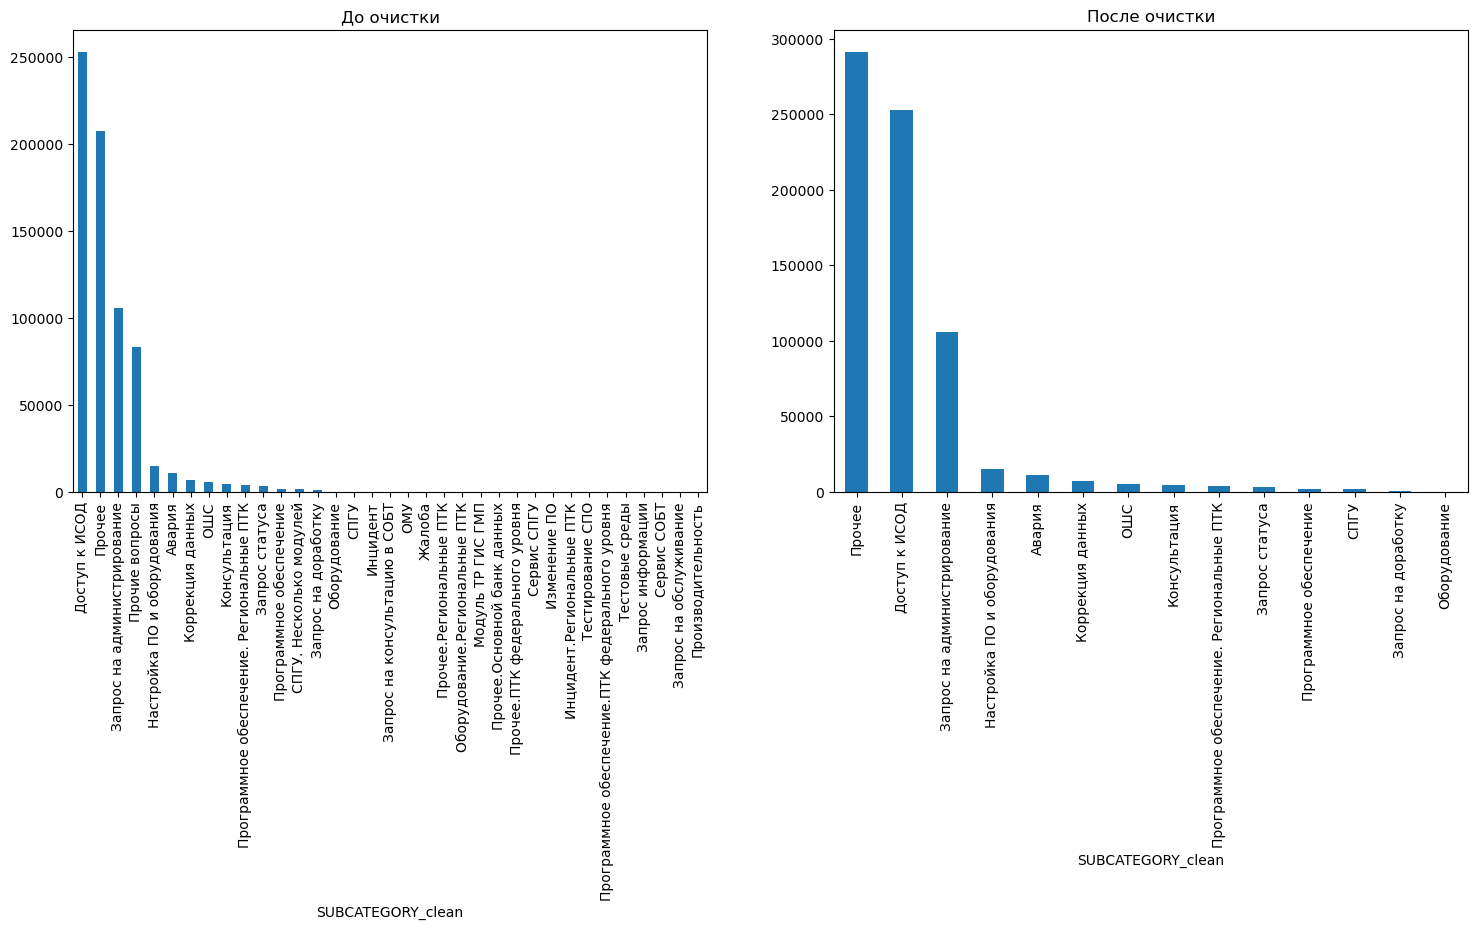

In [1182]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

counts.plot(kind='bar', ax=axes[0], title="До очистки")
df['SUBCATEGORY_clean'].value_counts().plot(kind='bar', ax=axes[1], title="После очистки")

In [1188]:
# Сохраняем результат
df.to_csv("../data/processed/cleaned_dataset.csv", index=False)